# This kernel contains the solution codes for the 	Pump it Up: Data Mining the Water Table competition of www.drivendata.org competition website

Our goal is to predict the operating condition of a waterpoint for each record in the test dataset. The predictors are like the population in the region, the values of latitudes, longitudes etc.

Importing the necessary packages

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

Reading the train dataset, test dataset and the target for the train dataset from the train labels file

In [32]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train_target = pd.read_csv("train labels.csv")

In [33]:
print("head of train")
train.head(1)

head of train


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [34]:
print("head of test")
test.head(1)

head of test


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other


In [35]:
print("head of train labels")
train_target.head(1)

head of train labels


,id,status_group
0,69572,functional


In [36]:
train = train.drop(["id"], axis = 1) #Dropping the id from the train dataset as it will not help in any way in predicting the target
test_ids = test['id'] #Keeping the test ids in a separate file for final prediction
test = test.drop(["id"], axis = 1) #Again dropping the ids from the test dataset as they are not going to help in final prediction
train_target = train_target.drop(["id"], axis = 1) #Similarly dropping the ids from the train labels dataset

In [37]:
print ("The shape of the train dataset is " + str(train.shape))
print ("The shape of the test dataset is " + str(test.shape))

The shape of the train dataset is (59400, 39)
The shape of the test dataset is (14850, 39)


So there are 39 features that are in some way contributing or not contributing to the classification of the pumps. We will have to design a model based on the features available so that our accuracy of the status of the pumps is highest

Lets check out the nature of the train dataset

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 39 columns):
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
recorded_by              59400 non-null object


Lets examine one feature at a time. We will look for opportunities for feature engineering. Feature engineering is one of the best methods by which we can increase the accuracy of our model. But first of all, lets check how many classes of target variable is present

In [39]:
print ("The number of classes in target variable are ")
train_target['status_group'].value_counts()

The number of classes in target variable are 


functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

So it is a multiclass classfication problem. The classes are functional, non functional and functional needs repair

In [40]:
proportion = (train_target['status_group'].value_counts()/train_target['status_group'].value_counts().sum())
proportion

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

# Joining the train and test dataset so as to prevent doing the same operation on train and test dataset twice

In [41]:
df = train.append(test, ignore_index = True)

In [42]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


# For the continuous variables
1. For variable amount_tsh, most of the values are 0.  
2. The latitude values are between -5.7 to -2. Similarly the longitude values are between 34.07 and 40.34.  
3. No description is available for num_private variable so we will have to drop this variable.  
4. Since we have latitudes and longitudes, we will drop the region_codes and district_codes variables 
5. Population and construction year might have a significant impact on the outcome. However these two variables have a lot of zeros which is not logical. It means that all these zeros are missing values and we will have treat these zeros. We will fill these zeros of population with median value and the zeros of construction year with the most frequent value

In [43]:
df = df.drop(['num_private'], axis = 1)

# Total Static Head

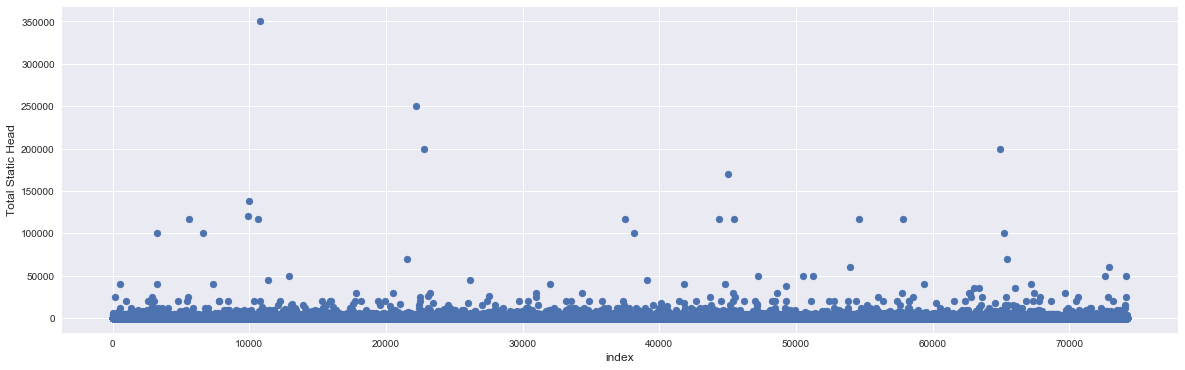

In [44]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.amount_tsh.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('Total Static Head', fontsize=12)
plt.show()

There are some outliers in the total static head. We will merge those outliers

In [45]:
ulimit_df = np.percentile(df.amount_tsh.values, 99.9)
df.amount_tsh.ix[df.amount_tsh.values>ulimit_df] = ulimit_df

# GPS Height

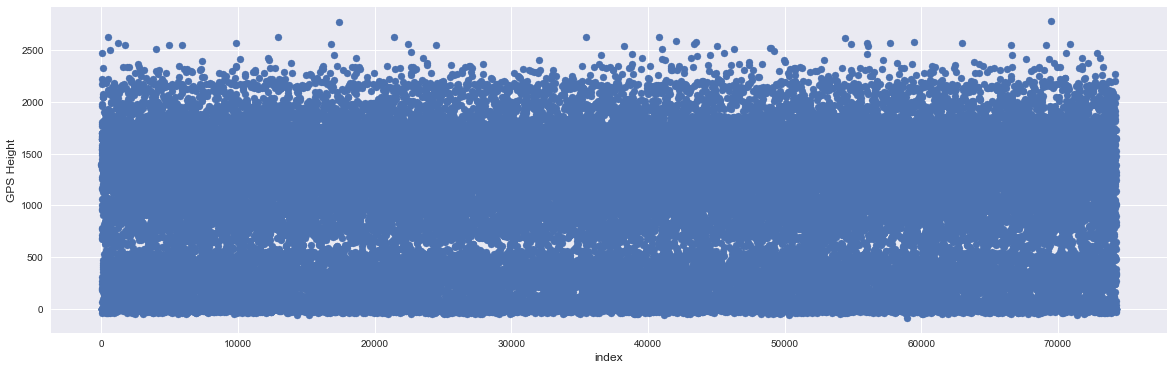

In [46]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.gps_height.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('GPS Height', fontsize=12)
plt.show()

The GPS height is evenly distributed. We will not touch them

# Longitude

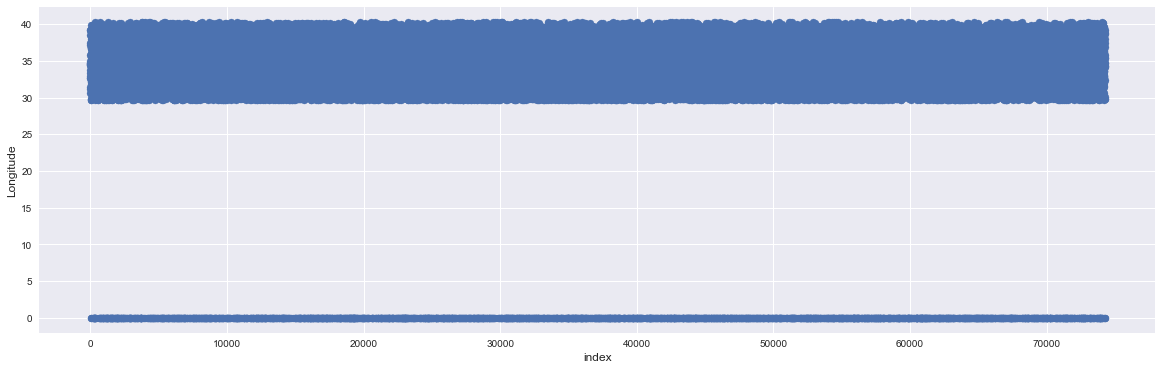

In [47]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.longitude.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('Longitude', fontsize=12)
plt.show()

# Latitude

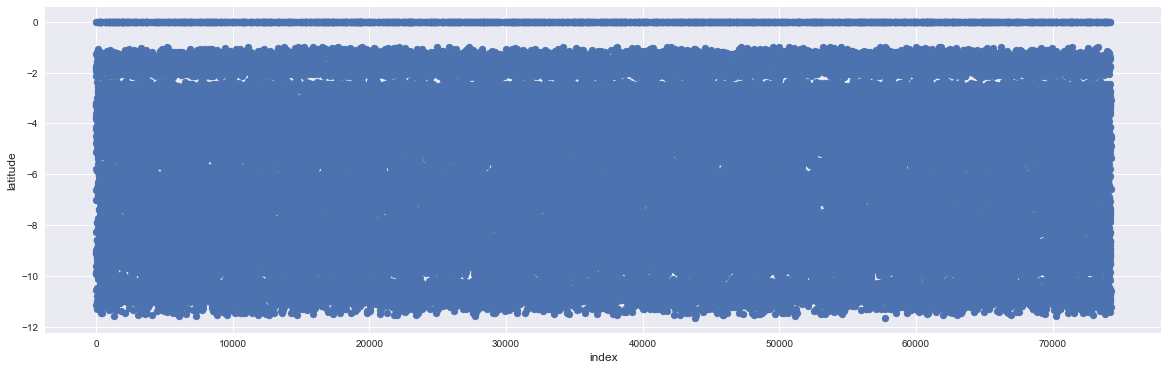

In [48]:
plt.figure(figsize=(20,6))
plt.scatter(range(df.shape[0]), df.latitude.values)
plt.xlabel('index', fontsize=12)
plt.ylabel('latitude', fontsize=12)
plt.show()

Since we already have latitudes and longitudes. So we are going to drop the region_codes and district_codes

In [49]:
df = df.drop(['region_code','district_code'], axis = 1)

Treating the missing values of population and construction year

In [50]:
(df['population']==0).value_counts()

False    47416
True     26834
Name: population, dtype: int64

In [51]:
(df['construction_year']==0).value_counts()

False    48281
True     25969
Name: construction_year, dtype: int64

We will fill the missing values of population with the median and the construction year with the most frequent value

In [52]:
df['population'] = df['population'].fillna(df['population'].median())
if df['construction_year'].value_counts().index[0]==0:
    df['construction_year'] = df['construction_year'].fillna(df['construction_year'].value_counts().index[1])
else:
    df['construction_year'] = df['construction_year'].fillna(df['construction_year'].value_counts().index[0])

In [53]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,population,construction_year
count,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000
mean,276.167186,665.667313,34.074262,-5.701771e+00,180.750828,1298.463650
std,1255.914955,692.761033,6.572519,2.944969e+00,471.086120,952.349375
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,0.000000
25%,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,0.000000
50%,0.000000,364.000000,34.907475,-5.026540e+00,25.000000,1986.000000
75%,20.000000,1317.000000,37.181685,-3.325058e+00,215.000000,2004.000000
max,20000.000000,2777.000000,40.345193,-2.000000e-08,30500.000000,2013.000000


In [54]:
cont = []
for col in df.columns.values:
    if df[col].dtype != 'object':
        cont.append(col)
df_cont = df[cont]
df_cat = df.drop(cont, axis=1)
print ("The categorical variables in the dataset are")
df_cat.head(1)

The categorical variables in the dataset are


,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,Iringa,Ludewa,Mundindi,True,GeoData Consultants Ltd,VWC,Roman,False,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [55]:
df_cat.describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,recorded_by,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,70095,74250,69404,38992,70457,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,369,2140,2410,45684,9,21425,21,125,2098,2,1,12,2868,2,18,13,7,12,5,7,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,GeoData Consultants Ltd,VWC,K,True,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,695,11299,21751,4440,12871,646,6599,3128,386,63749,74250,45917,858,48606,33263,33263,33263,50624,65538,31712,31712,63505,63505,41522,41522,21216,21216,57286,35628,43239


In [56]:
for col in df_cat.columns.values:
    if np.sum(df_cat[col].isnull())>0:
        value = np.sum(df_cat[col].isnull())
        print(col,value)

funder 4504
installer 4532
subvillage 470
public_meeting 4155
scheme_management 4846
scheme_name 35258
permit 3793


# For the categorical variables
1. We will modify the date recorded variable and take only the year
2. We will drop the funder variable as I am not able to see how funder can affect the status of the pump.
3. Installer might be a very important variable. We will impute the missing the missing values with the most frequent values
4. Water point name wpt_name variable is not important as the name of the waterpoint will not have any impact on the status of the pump
5. We are going to drop the variable region, subvillage, lga and ward (These variables are representing the geographical location) as we already have the latitude and longitude values
6. We will drop the public meeting variable
7. From the description of the dataset, the scheme name and the scheme management variables seem to be similar. We will keep the scheme management variable and drop the scheme name variable as it has a lot of missing values
8. We will fill the NA values of permit variable with the most frequent value.
9. Out of extraction_type, extraction_type_group, extraction_type-class, we are going to keep only the extraction_type variable. These three variables are similar. The number of unique values in this feature is the highest and that is why we are going to keep this variable.
10. Out of payment and payment_type variables we will keep only one variable
11. We will drop the water_quality, quality_group. Quality will not have an impact on 
12. Out of quantity and quantity_type variables we keep only one variable
13. Out of source, source_type, source_class we will keep the source variable as these three variables are quite similar and the source variable has the most variations
14. Out of waterpoint_type and waterpoint_type_group we will keep the waterpoint_type variable as these two variables are quite similar and the waterpoint_type variable has the most variations

In [57]:
df["entered_year"] = pd.to_datetime(df["date_recorded"]).dt.year
df = df.drop(['date_recorded','funder','wpt_name','region','scheme_name','subvillage','region','lga','ward',
              'public_meeting','extraction_type_group','extraction_type_class','payment_type','water_quality',
              'quality_group','quantity_group','source_type','source_class','waterpoint_type_group'], axis = 1)
cols = ['installer','scheme_management','permit']
for col in cols:
    if df[col].value_counts().index[0]==0:
        df[col] = df[col].fillna(df[col].value_counts().index[1])
    else:
        df[col] = df[col].fillna(df[col].value_counts().index[0])

The variables installer, subvillage, region_codes, district_codes, ward, lga has lots of classes. So we will have to decrease the classes. We will divide the  dataframe again into train and test.

In [58]:
train = df.iloc[:59400,:]
test = df.iloc[59400:,:]

We are going to print the number of unique classes of installer

In [59]:
train_installers_list = train.installer.unique()
test_installers_list = test.installer.unique()
print("Number of installers in Train dataset: {0}".format(len(train_installers_list)))
print("Number of installers in Test dataset: {0}".format(len(test_installers_list)))

Number of installers in Train dataset: 2145
Number of installers in Test dataset: 1091


We are going to see how many classes of installer are present in train and absent in test and vice versa

In [60]:
installers_not_in_test = set(train_installers_list) - set(test_installers_list)
installers_not_in_train = set(test_installers_list) - set(train_installers_list)

print("{} installers are featured in train dataset but not in test dataset".format(len(installers_not_in_test)))
print("{} installers are featured in test dataset but not in train dataset".format(len(installers_not_in_train)))

1319 installers are featured in train dataset but not in test dataset
265 installers are featured in test dataset but not in train dataset


We will create another dataframe with installer and the dummified target variable

In [61]:
train_installer_target = pd.concat([train['installer'],train_target], axis=1)
target_dummies = pd.get_dummies(train_installer_target['status_group'])
train_installer_target = train_installer_target.drop(['status_group'], axis = 1)
train_installer_target = pd.concat([train_installer_target,target_dummies], axis=1)
train_installer_target.head(2)

,installer,functional,functional needs repair,non functional
0,Roman,1,0,0
1,GRUMETI,1,0,0


We are going to group the installers and get the proportion for each status of target for each individual installer

In [62]:
train_installer_target_prop = pd.concat([train_installer_target.groupby('installer').mean(),train_installer_target.groupby('installer').count()], axis = 1).iloc[:,:-2]
train_installer_target_prop.columns = ['functional','functional needs repair','non functional','count']
train_installer_target_prop.sort_values(by='count',ascending=False).head()

,functional,functional needs repair,non functional,count
installer,,,,
DWE,0.542955,0.097925,0.359120,21057
Government,0.293151,0.140274,0.566575,1825
RWE,0.252073,0.113599,0.634328,1206
Commu,0.683019,0.030189,0.286792,1060
DANIDA,0.516190,0.079048,0.404762,1050


1. So the idea is that for a certain installer, the proportion for functional is greater than 0.54 (the proportion of functional in the total target variable) then the installer installs functional pump. If the proportion for non functional is greater than 0.38, then the installer installs non functional pump and if the proportion for functional needs repair category is greater than 0.07, then the installer installs functional pumps which need repair.   
2. The ordering has been done in such a way that since the proportion category for functional needs repair is the least in target variable that is why our main target would be capture the pumps which need repair. So if for a certain installer, the proportion for functional, functional needs repair, non functional is 0.54XX, 0.38XX, 0.07XX, then the category for that intaller would be functional needs repair, since that category comes last in the below code
3. Our target is to get the minority class right which is non functional. So weare going to change the proportion for non functional to 0.05XX

In [63]:
train_installer_target_prop['category'] = np.zeros((train_installer_target_prop.shape[0],1))
train_installer_target_prop['category'].loc[train_installer_target_prop['functional'] > 0.54] = 'functional'
train_installer_target_prop['category'].loc[train_installer_target_prop['non functional'] > 0.38] = 'non functional'
train_installer_target_prop['category'].loc[train_installer_target_prop['functional needs repair'] > 0.05] = 'functional needs repair'

Creating additional variables installer category  variable which will store whether that installer is contributing towards which status of pump

In [64]:
train['installer_category'] = train.installer.map(train_installer_target_prop.category)
test['installer_category'] = test.installer.map(train_installer_target_prop.category)
test['installer_category'] = test['installer_category'].fillna(test['installer_category'].value_counts().index[0])

Dropping the installer since we have done feature engineering on it

In [65]:
df = train.append(test, ignore_index = True)
df = df.drop(['installer'], axis = 1)

In [66]:
df.describe(include = ['O'])

,basin,recorded_by,scheme_management,extraction_type,management,management_group,payment,quantity,source,waterpoint_type,installer_category
count,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,9,1,12,18,12,5,7,5,10,7,3
top,Lake Victoria,GeoData Consultants Ltd,VWC,gravity,vwc,user-group,never pay,enough,spring,communal standpipe,functional needs repair
freq,12871,74250,50763,33263,50624,65538,31712,41522,21216,35628,47078


recorded_by variable only has one value. So we are going to drop this variable

In [67]:
df = df.drop(['recorded_by'], axis =1)

In [68]:
df['operation_year'] = df['entered_year'] - df['construction_year']

In [69]:
df = df.drop(['entered_year','construction_year'], axis = 1)

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 17 columns):
amount_tsh            74250 non-null float64
gps_height            74250 non-null int64
longitude             74250 non-null float64
latitude              74250 non-null float64
basin                 74250 non-null object
population            74250 non-null int64
scheme_management     74250 non-null object
permit                74250 non-null bool
extraction_type       74250 non-null object
management            74250 non-null object
management_group      74250 non-null object
payment               74250 non-null object
quantity              74250 non-null object
source                74250 non-null object
waterpoint_type       74250 non-null object
installer_category    74250 non-null object
operation_year        74250 non-null int64
dtypes: bool(1), float64(3), int64(3), object(10)
memory usage: 9.1+ MB


In [71]:
df_dummies = pd.get_dummies(df)

In [72]:
df_dummies.head()

,amount_tsh,gps_height,longitude,latitude,population,permit,operation_year,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,scheme_management_Company,scheme_management_None,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,extraction_type_afridev,extraction_type_cemo,extraction_type_climax,extraction_type_gravity,extraction_type_india mark ii,extraction_type_india mark iii,extraction_type_ksb,extraction_type_mono,extraction_type_nira/tanira,extraction_type_other,extraction_type_other - mkulima/shinyanga,extraction_type_other - play pump,extraction_type_other - rope pump,extraction_type_other - swn 81,extraction_type_submersible,extraction_type_swn 80,extraction_type_walimi,extraction_type_windmill,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,management_group_commercial,management_group_other,management_group_parastatal,management_group_unknown,management_group_user-group,payment_never pay,payment_other,payment_pay annually,payment_pay monthly,payment_pay per bucket,payment_pay when scheme fails,payment_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity_seasonal,quantity_unknown,source_dam,source_hand dtw,source_lake,source_machine dbh,source_other,source_rainwater harvesting,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other,installer_category_functional,installer_category_functional needs repair,installer_category_non functional
0,6000.0,1390,34.938093,-9.856322,109,False,12,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0
1,0.0,1399,34.698766,-2.147466,280,True,3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,25.0,686,37.460664,-3.821329,250,True,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
3,0.0,263,38.486161,-11.155298,58,True,27,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.0,0,31.130847,-1.825359,0,True,2011,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [74]:
df_dummies.shape

(74250, 95)

In [75]:
train = df_dummies.iloc[:59400,:]
test = df_dummies.iloc[59400:,:]

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [77]:
classifiers = [LogisticRegression(solver='lbfgs', multi_class='multinomial', C = 3000, tol = 0.0001),
               KNeighborsClassifier(n_neighbors = 15),
               GaussianNB(),
               RandomForestClassifier(n_estimators=500, random_state = 8)]

In [78]:
for clf in classifiers:
    name = clf.__class__.__name__
    Score = cross_val_score(clf, train, np.ravel(train_target), scoring = 'accuracy',cv=5).mean()
    
    print("="*30)
    print(name)
    
    print('****Results****')
    print("Score: {}".format(Score))
    
print("="*30)

LogisticRegression
****Results****
Score: 0.6641417755154471
KNeighborsClassifier
****Results****
Score: 0.6963970799078603
GaussianNB
****Results****
Score: 0.5212293872432676
RandomForestClassifier
****Results****
Score: 0.8031480798606594


In [79]:
cats = []
for col in df.columns.values:
    if df[col].dtype == 'object':
        cats.append(col)
df_cat = df[cats]
df_cont = df.drop(cats, axis=1)

Lets see if normalizing the continuous variables can increase the prediction power of the models

In [80]:
from sklearn.preprocessing import StandardScaler

In [81]:
for col in df_cont.columns.values:
    df_cont[col] = StandardScaler().fit_transform(df_cont[col].reshape(1,-1))[0]

In [82]:
df_norm = df_cont.join(df_cat)

In [83]:
df_norm_dummies = pd.get_dummies(df_norm)

In [84]:
train = df_norm_dummies.iloc[:59400,:]
test = df_norm_dummies.iloc[59400:,:]

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 17 columns):
amount_tsh            74250 non-null float64
gps_height            74250 non-null int64
longitude             74250 non-null float64
latitude              74250 non-null float64
basin                 74250 non-null object
population            74250 non-null int64
scheme_management     74250 non-null object
permit                74250 non-null bool
extraction_type       74250 non-null object
management            74250 non-null object
management_group      74250 non-null object
payment               74250 non-null object
quantity              74250 non-null object
source                74250 non-null object
waterpoint_type       74250 non-null object
installer_category    74250 non-null object
operation_year        74250 non-null int64
dtypes: bool(1), float64(3), int64(3), object(10)
memory usage: 9.1+ MB


In [86]:
for clf in classifiers:
    name = clf.__class__.__name__
    Score = cross_val_score(clf, train, np.ravel(train_target), scoring = 'accuracy',cv=5).mean()
    
    print("="*30)
    print(name)
    
    print('****Results****')
    print("Score: {}".format(Score))
    
print("="*30)

LogisticRegression
****Results****
Score: 0.7368687611654726
KNeighborsClassifier
****Results****
Score: 0.753720627332321
GaussianNB
****Results****
Score: 0.3010110560202316
RandomForestClassifier
****Results****
Score: 0.7771717251980308


Normalizing the continuous variables increased the score of logistic regression and KNN but it reduced the score of Random forest. Since we are going to use Random forest as our model, so we are going to take non normalized continuous variables

In [87]:
train = df_dummies.iloc[:59400,:]
test = df_dummies.iloc[59400:,:]

In [88]:
model = RandomForestClassifier(n_estimators=500, random_state=8)
model.fit(train,np.ravel(train_target))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=8,
            verbose=0, warm_start=False)

In [89]:
test_predictions = model.predict(test)

In [90]:
submission = pd.DataFrame(test_predictions, columns=['status_group'])
submission.insert(0, 'id', test_ids)
submission.reset_index()
submission.to_csv('submission.csv', index = False)

In [91]:
submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [92]:
submission['status_group'].value_counts()

functional                 8591
non functional             5467
functional needs repair     792
Name: status_group, dtype: int64

In [93]:
proportion = (submission['status_group'].value_counts()/submission['status_group'].value_counts().sum())
proportion

functional                 0.578519
non functional             0.368148
functional needs repair    0.053333
Name: status_group, dtype: float64

We can see above that the category functional needs repair is very low. Its proportion in the train dataset is 7% but here it is 4%. Let us see if we can increase that

We are going to do some feature engineering on the categorical variables and see if it improves the prediction power of the model. It is always good to do feature engineering on a new dataframe s o that you are able to return to the original dataframe if things do not go according to plan.

In [94]:
cat_train = df.iloc[:59400,:]
df_modified = df

In [95]:
cat_train.describe(include = ['O'])

,basin,scheme_management,extraction_type,management,management_group,payment,quantity,source,waterpoint_type,installer_category
count,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,9,12,18,12,5,7,5,10,7,3
top,Lake Victoria,VWC,gravity,vwc,user-group,never pay,enough,spring,communal standpipe,functional needs repair
freq,10248,40670,26780,40507,52490,25348,33186,17021,28522,37518


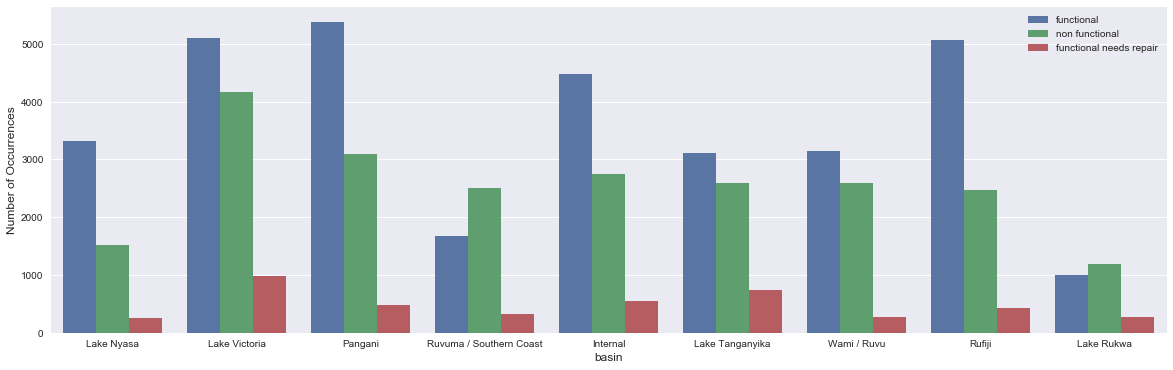

In [96]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['basin'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('basin', fontsize=12)
plt.show()

We are going to create a new variable 'basin_modified' which will be binary based on basin being 'Ruvuma/Southern Coast or 'Lake Rukwa' because these two classes are showing different characteristic(non functional is greater than functional).

In [97]:
df_modified['basin_modified']= np.zeros(df.shape[0])
df_modified['basin_modified'].loc[(df_modified['basin'] == 'Ruvuma/Southern Coast') | (df_modified['basin'] == 'Lake Rukwa')] = 1

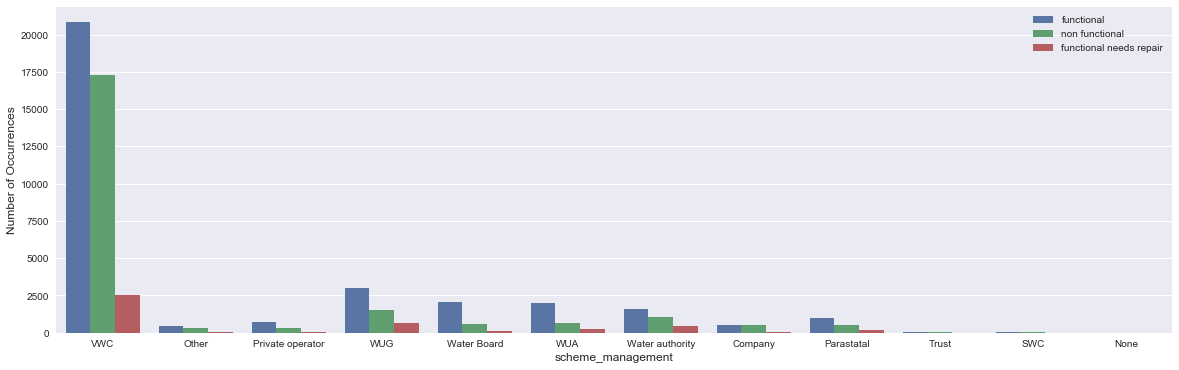

In [98]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['scheme_management'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('scheme_management', fontsize=12)
plt.show()

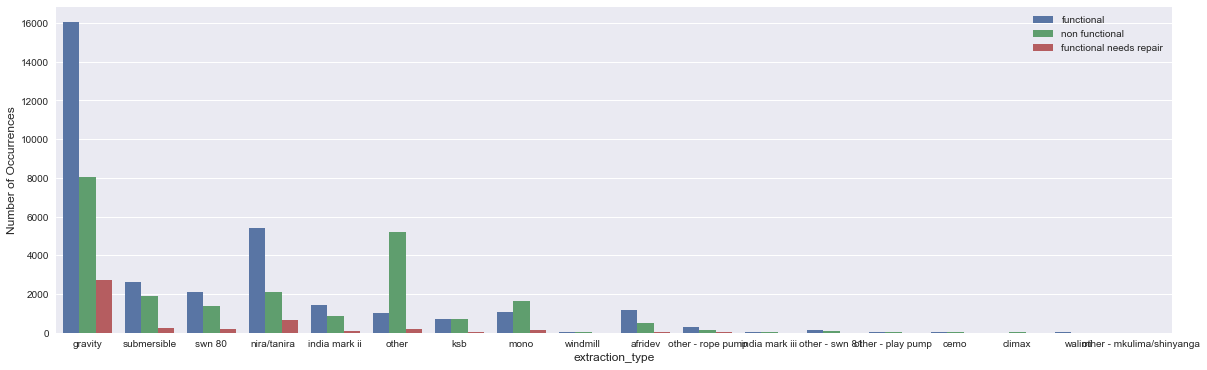

In [99]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['extraction_type'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('extraction_type', fontsize=12)
plt.show()

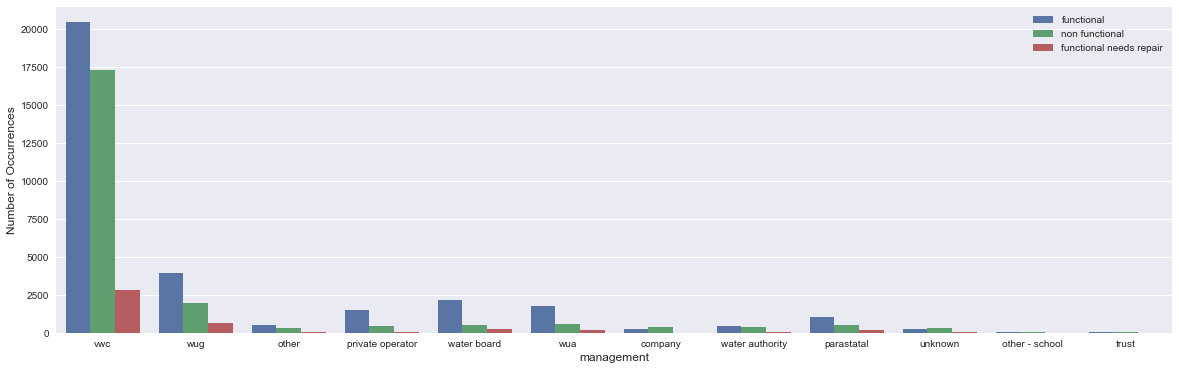

In [100]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['management'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management', fontsize=12)
plt.show()

management and scheme_management seem to be similar variables. We will drop management variable

In [101]:
df_modified = df_modified.drop(['management'], axis = 1)

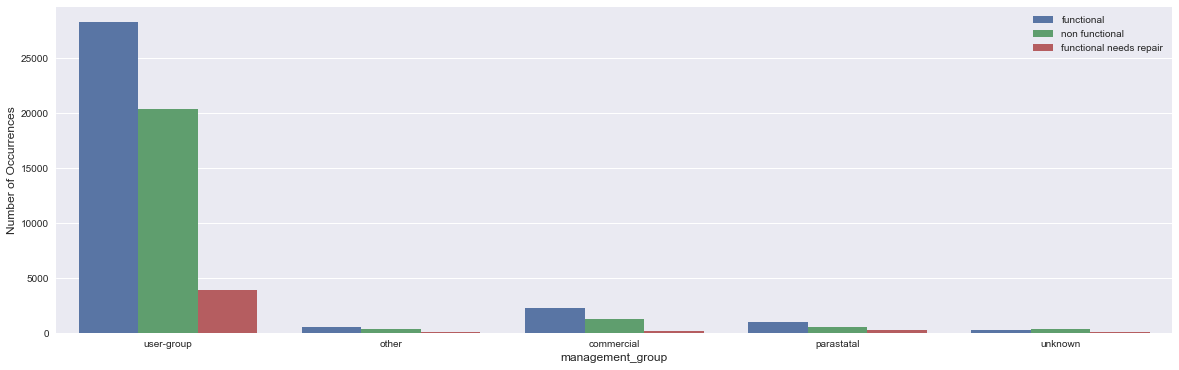

In [102]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['management_group'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('management_group', fontsize=12)
plt.show()

The classes will be categorized into user-group and other classes

In [103]:
df_modified['management_group'].loc[df_modified['management_group'] != 'user-group'] = 'others'

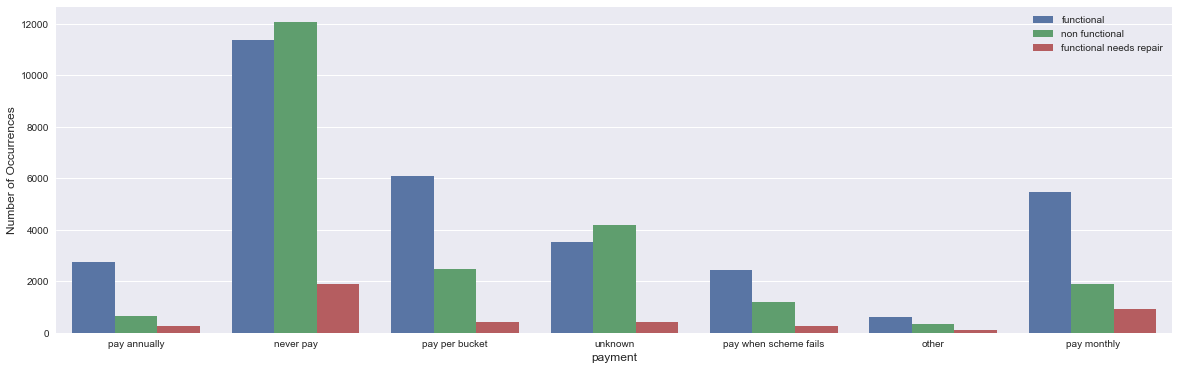

In [104]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['payment'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('payment', fontsize=12)
plt.show()

We are going to create a new variable 'payment_modified' which will be binary based on payment being 'never pay' or 'unknown payment' because these two classes are showing different characteristic(non functional is greater than functional).

In [105]:
df_modified['payment_modified']= np.zeros(df.shape[0])
df_modified['payment_modified'].loc[(df_modified['payment'] == 'never pay') | (df_modified['payment'] == 'unknown payment')] = 1

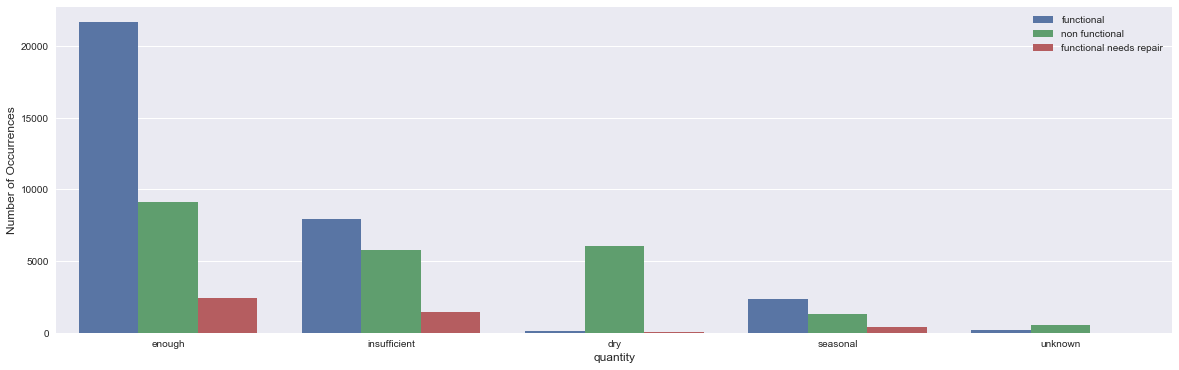

In [106]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['quantity'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('quantity', fontsize=12)
plt.show()

We are going to create a new variable 'quantity_modified' which will be binary based on payment being 'dry' or 'unknown' because these two classes are showing different characteristic(non functional is greater than functional).

In [107]:
df_modified['quantity_modified']= np.zeros(df.shape[0])
df_modified['quantity_modified'].loc[(df_modified['quantity'] == 'dry') | (df_modified['quantity'] == 'unknown')] = 1

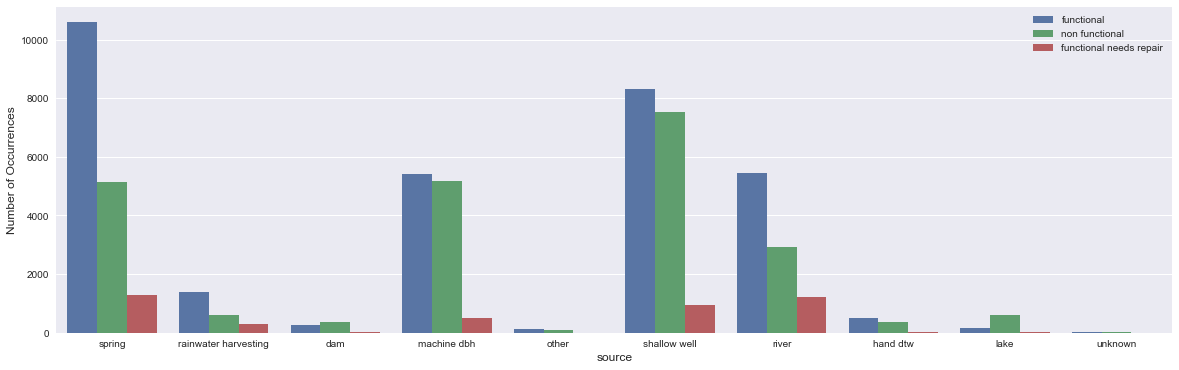

In [108]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['source'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('source', fontsize=12)
plt.show()

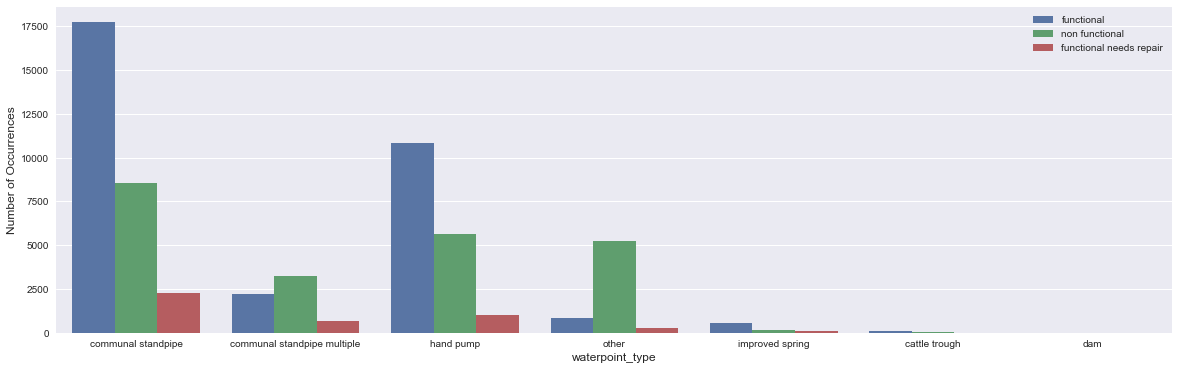

In [109]:
plt.figure(figsize=(20,6))
sns.countplot(cat_train['waterpoint_type'], hue = train_target['status_group'])
plt.legend(loc='upper right')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('waterpoint_type', fontsize=12)
plt.show()

We are going to create a new variable 'waterpoint_type_modified' which will be binary based on payment being 'communal standpipe multiple' or 'other' because these two classes are showing different characteristic(non functional is greater than functional).

In [110]:
df_modified['waterpoint_type_modified']= np.zeros(df.shape[0])
df_modified['waterpoint_type_modified'].loc[(df_modified['waterpoint_type'] == 'communal standpipe multiple') | (df_modified['waterpoint_type'] == 'other')] = 1

In [111]:
df_dummies_modified = pd.get_dummies(df_modified)
train_modified = df_dummies_modified.iloc[:59400,:]
clf = RandomForestClassifier(n_estimators=500, random_state = 8)
Score = cross_val_score(clf, train_modified, np.ravel(train_target), scoring = 'accuracy',cv=5).mean()
Score

0.80358579030409616

The operations on the categorical variables is decreasing the predictive power of the model. So we are not going to use the modified dataframe where feature engineering was done on categorical variables

In [112]:
clf.fit(train, np.ravel(train_target))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=8,
            verbose=0, warm_start=False)

In [113]:
train.shape

(59400, 95)

In [115]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    
Imp_var = []
for i in range(0,90):
    Imp_var.append(indices[i])
print (Imp_var)
df_dummies_new = df_dummies[Imp_var]
df_dummies_new.columns.values

Feature ranking:
1. feature 2 (0.156959)
2. feature 3 (0.155322)
3. feature 70 (0.076252)
4. feature 1 (0.074514)
5. feature 6 (0.059438)
6. feature 4 (0.052372)
7. feature 91 (0.031766)
8. feature 71 (0.025747)
9. feature 37 (0.025640)
10. feature 0 (0.024443)
11. feature 92 (0.021527)
12. feature 94 (0.018175)
13. feature 72 (0.014196)
14. feature 63 (0.012130)
15. feature 86 (0.011197)
16. feature 5 (0.011151)
17. feature 93 (0.010444)
18. feature 89 (0.009751)
19. feature 87 (0.009237)
20. feature 31 (0.008288)
21. feature 83 (0.007977)
22. feature 36 (0.007388)
23. feature 69 (0.006881)
24. feature 73 (0.006811)
25. feature 78 (0.006569)
26. feature 53 (0.006512)
27. feature 67 (0.006262)
28. feature 82 (0.006057)
29. feature 23 (0.005943)
30. feature 66 (0.005589)
31. feature 7 (0.005480)
32. feature 81 (0.005420)
33. feature 11 (0.004883)
34. feature 10 (0.004510)
35. feature 80 (0.004224)
36. feature 13 (0.004172)
37. feature 12 (0.004127)
38. feature 15 (0.004044)
39. feature 

array(['longitude', 'latitude', 'quantity_dry', 'gps_height',
       'operation_year', 'population', 'waterpoint_type_other',
       'quantity_enough', 'extraction_type_other', 'amount_tsh',
       'installer_category_functional',
       'installer_category_non functional', 'quantity_insufficient',
       'payment_never pay', 'waterpoint_type_communal standpipe', 'permit',
       'installer_category_functional needs repair',
       'waterpoint_type_hand pump',
       'waterpoint_type_communal standpipe multiple',
       'extraction_type_gravity', 'source_spring',
       'extraction_type_nira/tanira', 'payment_unknown',
       'quantity_seasonal', 'source_machine dbh', 'management_vwc',
       'payment_pay per bucket', 'source_shallow well',
       'scheme_management_VWC', 'payment_pay monthly', 'basin_Internal',
       'source_river', 'basin_Lake Victoria', 'basin_Lake Tanganyika',
       'source_rainwater harvesting', 'basin_Rufiji', 'basin_Pangani',
       'basin_Wami / Ruvu', 'basin

In [116]:
for clf in classifiers:
    name = clf.__class__.__name__
    Score = cross_val_score(clf, train, np.ravel(train_target), scoring = 'accuracy',cv=5).mean()
    
    print("="*30)
    print(name)
    
    print('****Results****')
    print("Score: {}".format(Score))
    
print("="*30)

LogisticRegression
****Results****
Score: 0.6641417755154471
KNeighborsClassifier
****Results****
Score: 0.6963970799078603
GaussianNB
****Results****
Score: 0.5212293872432676
RandomForestClassifier
****Results****
Score: 0.8031480798606594


Seems like not much improvement is happeing. We are going to go with the earlier submission file that we created